# Building Scalable Drug Discovery Applications: Active Learning

Note: This notebook was last tested on and Amazon SageMaker Studio JupyterLab space on a ml.g4dn.xlarge instance.

### How can antibody-based drugs help fight disease?

Antibody drugs, also known as monoclonal antibodies or immunotherapies, are an important class of medications used to treat various diseases. 

Examples of diseases treated with antibody drugs include:

- Cancer: Drugs like trastuzumab (Herceptin) for HER2-positive breast cancer or pembrolizumab (Keytruda) for various cancers.

- Autoimmune disorders: Drugs such as adalimumab (Humira) for rheumatoid arthritis and Crohn's disease.

- Infectious diseases: Antibody cocktails for Ebola virus or COVID-19.

- Allergic conditions: Omalizumab (Xolair) for severe asthma and chronic hives.

- Neurological disorders: Drugs like ocrelizumab (Ocrevus) for multiple sclerosis.

Antibody drugs have revolutionized the treatment of many diseases, offering targeted therapies with often fewer side effects than traditional small-molecule drugs.

### How can active learning accelerate drug discovery?

Research team working on antibody-based drugs may need to generate and test many thousands of candidates before they find one with the best mix of properties. This can be very expensive and take a long time. 

Active learning is a machine learning technique where the predictive algorithm actively participates in the training data selection process, rather than passively learning from a fixed dataset. The key idea behind active learning is to reduce the amount of labeled training data needed to reach your goal by intelligently picking the right examples.

This is very useful when it is very expensive or difficult to generate training data, like in the case of drug development! Let's say we want to predict a property for 100,000 drug candidates. We could test them all, but it would take a while. Instead, we can test a few and use them to train a ML model. We then use the model to predict the property value for all candidates. Finally, we use a strategy to pick a few more samples and repeat until we reach our goal.

![Active learning can accelerate DMTL cycles](img/active_learning.png)

### What is the goal of this notebook?

In this example, we will use active learning to predict a property ("Factor X") for a large number of "nanobody" molecules. A nanobody is a small antibody fragment derived from camelids like camels and llamas. Nanobodies are much smaller than typical antibodies, allowing them to access targets and bind to regions that larger antibody molecules cannot reach. They are also very stable and can be easily engineered to modify their properties.

This workflow generates nanobody molecules based off a commonly-used scaffold, NbBCII10 humanized (FGLA mutant). The generated molecules share the same sequence as the scaffold EXCEPT for three so-called “complementarity determining regions” or CDRs, highlighted in orange below.  These sequence regions are responsible for much of the binding activity of various antibody formats, including nanobodies.

![Nanobody compared to an IgG antibody](img/nanobody.png)








---
## 1. Setup

In [1]:
%pip install -U -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import biotite
from biotite.structure.io import pdb
from biotite.database import rcsb
import helpers
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

SEQ_GENERATION_SIZE = 50000
LAB_SUBMISSION_SIZE = 384

2024-11-26 01:30:44.357480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 01:30:44.372113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 01:30:44.390802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 01:30:44.396501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 01:30:44.409939: I tensorflow/core/platform/cpu_feature_guar

---
## 2. View Nanobody sequence and structure

Let's download and explore the structure of a nanobody. In this case we'll look at Cablivi (Caplacizumab), the first humanized nanobody-based drug approved by the US FDA in 2019.

In [3]:
pdb_id = "7eow"
stack = biotite.structure.io.pdb.get_structure(
    pdb.PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
)
vf_factor = helpers.clean_structure(stack[0][stack.chain_id == "A"])
caplacizumab = helpers.clean_structure(stack[0][stack.chain_id == "B"])

caplacizumab_seq = biotite.structure.to_sequence(caplacizumab)[0][0]
cdr1 = list(range(25, 32))
cdr2 = list(range(51, 57))
cdr3 = list(range(98, 117))
cdrs = cdr1 + cdr2 + cdr3
cdrs_1_base = [i + 1 for i in cdrs]

preserved_regions = [
    (0, cdr1[0]),
    (cdr1[-1] + 1, cdr2[0]),
    (cdr2[-1] + 1, cdr3[0]),
    (cdr3[-1] + 1, len(caplacizumab_seq)),
]

print(caplacizumab_seq)
print(helpers.format_cdrs(caplacizumab_seq, cdrs))

EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRELVAAISRTGGSTYYPDSVEGRFTISRDNAKRMVYLQMNSLRAEDTAVYYCAAAGVRAEDGRVRTLPSEYTFWGQGTQVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRELVAAISRTGGSTYYPDSVEGRFTISRDNAKRMVYLQMNSLRAEDTAVYYCAAAGVRAEDGRVRTLPSEYTFWGQGTQVTVSS


The caplacizumab molecule is shown in blue below. The light-blue regions are the CDRs. These play the largest role in the drugs effect on its target and where we'll focus our attention.

In [4]:
import py3Dmol

view = py3Dmol.view(width=600, height=600)
view.addModel(helpers.to_pdb_string(vf_factor))
view.addModel(helpers.to_pdb_string(caplacizumab))
view.setStyle({"chain": "A"}, {"cartoon": {"color": "orange", "opacity": 0.6}})
view.setStyle({"chain": "B"}, {"cartoon": {"color": "blue", "opacity": 0.6}})
view.addStyle(
    {"chain": "B", "resi": cdrs_1_base},
    {"cartoon": {"color": "#57C4F8", "opacity": 1.0}},
)
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
## 3. Generate Sequence Variants

![Generate sequence variants using directed evolution](img/gen.png)

First, let's change some parts of the caplacizumab CDRs. This is similar to a process that natural antibodies go through in your body, known as affinity maturation. Sometimes researchers will also introduce mutations with chemicals or radiation to try and create new drugs. In our case, we'll create mutants computationally. There are some intelligent ways to do this, but for the sake of simplicity we'll do it randomly.

100%|██████████| 60000/60000 [00:11<00:00, 5382.16it/s]


Checking for duplicates


100%|██████████| 50000/50000 [00:02<00:00, 17662.68it/s]


Top score values: id
630088    0.546276
70ecb3    0.530295
7c942d    0.529559
897a19    0.521840
309f84    0.521796
Name: result, dtype: float64


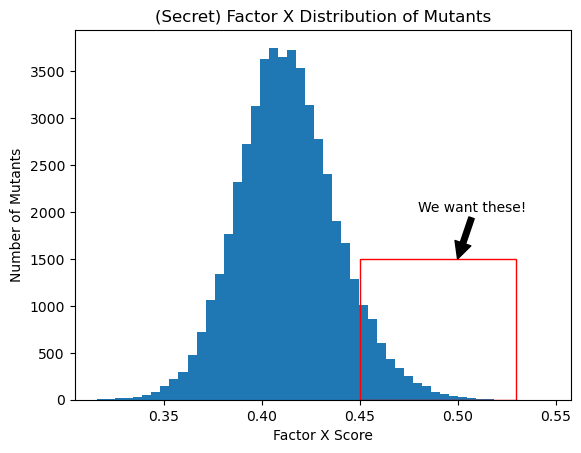

Generated 50000 sequences. Here's a preview:
EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRELVAAISRTGGSTYYPDSVEGRFTISRDNAKRMVYLQMNSLRAEDTAVYYCAAAGVRAEDGRVRTLPSEYTFWGQGTQVTVSS
---------------------------W--T----------------------L--G------------------------------------------------Q----------------------
----------------------------CW-------------------------W------------------------------------------G--------RY--I----------------
--------------------------CNNR-----------------------W--G-------------------------------------------------YI---L----------------
-----------------------------F------------------------M--------------------------------------------K--F-V--I--------------------
-------------------------------D--------------------RL--------------------------------------------------------K-----------------
-------------------------------K------------------------M----------------------------------------------------I------------------
----------------------------------------------------

In [ ]:
generated_seqs = helpers.random_mutation(
    wt_protein=str(caplacizumab_seq),
    n_output_seqs=SEQ_GENERATION_SIZE,
    preserved_regions=preserved_regions,
    max_mutations=10,
    annotate_hist=True,
)
print(f"Generated {len(generated_seqs)} sequences. Here's a preview:")
n_preview = 10
print(caplacizumab_seq)
for i in generated_seqs.sample(n_preview).itertuples():
    print(helpers.format_cdrs(i.seq, i.mutation, mask=True))

In [6]:
generated_seqs

,seq,mutation,lab_result
id,,,
540186,EVQLVESGGGLVQPGGSLRLSCAASGRVFSTNPMGWFRQAPGKGRE...,"[101, 107, 100, 104, 30, 98, 27, 108, 56, 53]",NaN
1945b0,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[100, 111]",NaN
fb75a9,EVQLVESGGGLVQPGGSLRLSCAASGRTKSYNPMGWFRQAPGKGRE...,"[28, 111, 116, 111]",NaN
e149fc,EVQLVESGGGLVQPGGSLRLSCAASGRTFSLNPMGWFRQAPGKGRE...,"[104, 53, 56, 116, 115, 113, 30]",NaN
53c607,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[55, 99, 56, 109, 114]",NaN
...,...,...,...
732fa7,EVQLVESGGGLVQPGGSLRLSCAASGQTFSYNPMGWFRQAPGKGRE...,"[54, 112, 26]",NaN
620e1e,EVQLVESGGGLVQPGGSLRLSCAASGRTMSRNPMGWFRQAPGKGRE...,"[99, 99, 116, 30, 28]",NaN
984532,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[108, 55, 108, 106, 111, 54, 116]",NaN


In this case, we have a (secret) way of calculating Factor X values from the amino acid sequence of each mutant. In the real world this probably won't be the case. Instead, we'll need to measure it experimentally in a laboratory. Examining ALL of the mutants could be expensive and take a long time. So instead, let's use ML to find the highest-scoring mutants with the smallest amount of lab data.

---
## 4. Score Mutants with Protein Language Model

![Predict high-performing variants using a scoring model](img/score.png)

Before we start submitting samples to the lab, it would be great if we could filter down our list of mutants somehow. We don't have a fine-tuned model at this point to predict Factor X. However, we can use an alternative technique to score our mutants using another metric.

Protein Language Models (pLMs) are transformer-based ML models trained on millions of protein amino acid sequences using techniques from by the large language model community. These models have an innate understanding of what sequences are likely to have survived many billions of years of evolution. After all, if a particular protein sequence was nonfunctional, or caused a negative effect to its host organism, it probably would not have surived until today for us to measure it! For this reason, pLMs are useful for so-called "zero-shot likelihood analysis". In other words, you can take two sequences and predict which one is more likely to occur in nature.

In our case, we'll use the [AMPLIFY](https://github.com/chandar-lab/AMPLIFY) pLM to compare each of our mutant sequences to caplacizumab. That will allow us to focus on only those sequences that are at least as likely to survive as our original (wt) sequence.

First, we calculate the pseudo-log likelihood score for all mutants.

Analyzing wildtype sequence
Analyzing mutant sequences


100%|██████████| 98/98 [02:18<00:00,  1.42s/it]


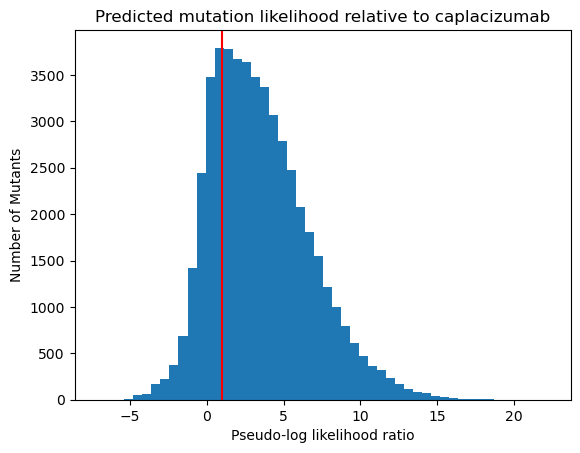

In [ ]:
wt_seq = str(caplacizumab_seq)
pllrs = helpers.compute_pseudo_log_likelihood_ratio(wt_seq, generated_seqs["seq"])

We remove all of the mutants with pllr less than one. 

In [ ]:
print(f"Records before filtering: {len(generated_seqs)}")
generated_seqs["pplr"] = pllrs
generated_seqs = generated_seqs[generated_seqs["pplr"] > 1]
print(f"Records after filtering: {len(generated_seqs)}")

Records before filtering: 50000
Records after filtering: 37876


---
## 5. Select Samples

![Identify candidates for lab testing using a selection model](img/select.png)

Let's select a few samples and use them to train our model. We don't know much about these mutants yet, so we'll start by picking a few at random.

In [9]:
no_lab_data = generated_seqs[generated_seqs["lab_result"].isnull()]
selected_seqs = no_lab_data.sample(n=LAB_SUBMISSION_SIZE)
selected_seqs

,seq,mutation,lab_result,pplr
id,,,,
880859,EVQLVESGGGLVQPGGSLRLSCAASGRTFSRIPMGWFRQAPGKGRE...,"[56, 114, 51, 30, 53, 107, 31]",NaN,3.153515
b15d24,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[102, 105, 99, 56, 56, 107]",NaN,2.498271
22c279,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[102, 115, 112, 106, 103, 100, 111, 116, 108]",NaN,1.604752
41ed2a,EVQLVESGGGLVQPGGSLRLSCAASSRTFSYNPMGWFRQAPGKGRE...,"[25, 103, 106, 101, 112, 104, 105]",NaN,2.046743
d67211,EVQLVESGGGLVQPGGSLRLSCAASVRTFSYNPMGWFRQAPGKGRE...,"[114, 100, 54, 106, 51, 25, 115, 114, 110, 25]",NaN,4.123451
...,...,...,...,...
5c7096,EVQLVESGGGLVQPGGSLRLSCAASGRPFSYNPMGWFRQAPGKGRE...,"[105, 98, 99, 104, 116, 103, 108, 111, 27, 106]",NaN,1.180142
aa45f1,EVQLVESGGGLVQPGGSLRLSCAASGRTFSMNPMGWFRQAPGKGRE...,"[30, 103, 100]",NaN,5.701993
6f3980,EVQLVESGGGLVQPGGSLRLSCAASGRTFAYNPMGWFRQAPGKGRE...,"[55, 106, 110, 106, 29, 98, 105, 51, 56, 113]",NaN,4.872811


---
## 6. Submit to Lab

![Submit selected samples for experimental testing](img/lab.png)

Next we'll submit them to the lab to test for "Factor X". Remember that in the real world this process could take days or even weeks, depending on the test!

In [ ]:
lab_results = helpers.submit_seqs_to_lab(selected_seqs["seq"])

for result in lab_results.itertuples():
    generated_seqs.loc[[result.Index], ["lab_result"]] = result.result

display(lab_results.sort_values(by="result", ascending=False))



   _____ __                  __   __               __      _____                           _                __           __                
  / ___// /_____ _____  ____/ /  / /_  ____ ______/ /__   /  _( )____ ___     ____ _____  (_)___  ____ _   / /_____     / /________  __    
  \__ \/ __/ __ `/ __ \/ __  /  / __ \/ __ `/ ___/ //_/   / / |// __ `__ \   / __ `/ __ \/ / __ \/ __ `/  / __/ __ \   / __/ ___/ / / /    
 ___/ / /_/ /_/ / / / / /_/ /  / /_/ / /_/ / /__/ ,<    _/ /   / / / / / /  / /_/ / /_/ / / / / / /_/ /  / /_/ /_/ /  / /_/ /  / /_/ /     
/____/\__/\__,_/_/ /_/\__,_/  /_.___/\__,_/\___/_/|_|  /___/  /_/ /_/ /_/   \__, /\____/_/_/ /_/\__, /   \__/\____/   \__/_/   \__, /      
                                                                           /____/              /____/                         /____/       
                888
.d8888b  .d8888b888 .d88b. 88888b.  .d8888b .d88b.   888
88K     d88P"   888d8P  Y8b888 "88bd88P"   d8P  Y8b  888
"Y8888b.888     88888888

100%|██████████| 384/384 [00:38<00:00,  9.93it/s]


,seq,result
id,,
b7649c,EVQLVESGGGLVQPGGSLRLSCAASGREFSYNPMGWFRQAPGKGRE...,0.497120
bf9829,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYYPMGWFRQAPGKGRE...,0.496394
e80e7e,EVQLVESGGGLVQPGGSLRLSCAASGRTFSHNPMGWFRQAPGKGRE...,0.492523
86cd3c,EVQLVESGGGLVQPGGSLRLSCAASIRWFSYNPMGWFRQAPGKGRE...,0.486701
ea48cf,EVQLVESGGGLVQPGGSLRLSCAASHRKFSYFPMGWFRQAPGKGRE...,0.483347
...,...,...
29a268,EVQLVESGGGLVQPGGSLRLSCAASGRTFSQNPMGWFRQAPGKGRE...,0.364860
513f50,EVQLVESGGGLVQPGGSLRLSCAASGRTFSSNPMGWFRQAPGKGRE...,0.359760
704ada,EVQLVESGGGLVQPGGSLRLSCAASGPTFSYNPMGWFRQAPGKGRE...,0.357808


---
## 7. Fine-Tune Property Prediction Model

![Improve the scoring model using experimental results](img/ft.png)

Isn't science great? With these results in hand we're ready to train a model. We don't have enough data to train a model with perfect accuracy (yet), but that's ok - our job is to get close enough to identify the best mutants to test next round. In this case, we'll fine-tune a small protein language model that was previously trained to understand common patterns in naturally-occuring protein sequences.

In [11]:
scoring_model = helpers.train_scoring_model(
    lab_results,
    sequence_column="seq",
    results_column="result",
    epochs=3,
    model_name_or_path="facebook/esm2_t12_35M_UR50D",
)

Running tokenizer on dataset:   0%|          | 0/307 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

{'loss': 0.0183, 'grad_norm': 0.3948057293891907, 'learning_rate': 8.632478632478634e-05, 'epoch': 0.41}
{'loss': 0.0011, 'grad_norm': 0.3682885766029358, 'learning_rate': 7.264957264957265e-05, 'epoch': 0.82}
{'eval_loss': 0.0010911477729678154, 'eval_runtime': 0.3005, 'eval_samples_per_second': 256.278, 'eval_steps_per_second': 33.283, 'epoch': 1.0}
{'loss': 0.0012, 'grad_norm': 0.2705570459365845, 'learning_rate': 5.897435897435898e-05, 'epoch': 1.23}
{'loss': 0.0008, 'grad_norm': 0.07711464911699295, 'learning_rate': 4.52991452991453e-05, 'epoch': 1.64}
{'eval_loss': 0.0007410033140331507, 'eval_runtime': 0.3007, 'eval_samples_per_second': 256.031, 'eval_steps_per_second': 33.251, 'epoch': 2.0}
{'loss': 0.0006, 'grad_norm': 0.09992176294326782, 'learning_rate': 3.162393162393162e-05, 'epoch': 2.05}
{'loss': 0.0006, 'grad_norm': 0.05557142198085785, 'learning_rate': 1.794871794871795e-05, 'epoch': 2.46}
{'loss': 0.0007, 'grad_norm': 0.02957778610289097, 'learning_rate': 4.2735042735

---
## 8. Score Samples with Property Prediction Model

![Predict high-performing variants using a scoring model](img/score.png)

Finally, we use our newly-trained model to predict the value of "Factor X" for all of our samples. This will give us a better idea of our mutants and help us pick another batch for lab testing.

In [12]:
predictions = helpers.run_scoring_model(generated_seqs, batch_size=1024)
generated_seqs["last_prediction"] = predictions
display(generated_seqs.sort_values(by="lab_result", ascending=False)[:5])

Running tokenizer on dataset (num_proc=4):   0%|          | 0/37876 [00:00<?, ? examples/s]

100%|██████████| 37/37 [02:13<00:00,  3.61s/it]
/tmp/ipykernel_17317/1530832216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_seqs["last_prediction"] = predictions


,seq,mutation,lab_result,pplr,last_prediction
id,,,,,
b7649c,EVQLVESGGGLVQPGGSLRLSCAASGREFSYNPMGWFRQAPGKGRE...,"[27, 53, 116, 102, 56, 105, 107, 104]",0.497120,5.097338,0.413239
bf9829,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYYPMGWFRQAPGKGRE...,"[31, 109, 112, 102, 110, 112, 53, 55, 105]",0.496394,6.742892,0.414065
e80e7e,EVQLVESGGGLVQPGGSLRLSCAASGRTFSHNPMGWFRQAPGKGRE...,"[30, 99, 113, 111, 115, 109, 102, 98, 30, 54]",0.492523,8.808591,0.413811
86cd3c,EVQLVESGGGLVQPGGSLRLSCAASIRWFSYNPMGWFRQAPGKGRE...,"[114, 99, 54, 25, 104, 112, 27, 99]",0.486701,8.371236,0.414444
ea48cf,EVQLVESGGGLVQPGGSLRLSCAASHRKFSYFPMGWFRQAPGKGRE...,"[99, 31, 56, 25, 53, 98, 27, 25, 103, 105]",0.483347,10.452606,0.416034


---
## 9. Put it all together!

Now let's try a few cycles. Feel free to modify the parameters below as you see fit. Remember that our goal is to find the mutant with the largest value of "Factor X", not necessarily to end up with the most accurate model.

In [13]:
SEQ_GENERATION_SIZE = 50000
MAX_MUTATIONS = 10
N_REPS = 3
LAB_SUBMISSION_SIZE = 384
MODEL_ID = "facebook/esm2_t12_35M_UR50D"
# MODEL_ID = "facebook/esm2_t30_150M_UR50D"
# MODEL_ID = "facebook/esm2_t33_650M_UR50D"

Generating 50000 random variants


100%|██████████| 60000/60000 [00:10<00:00, 5528.24it/s]


Checking for duplicates


100%|██████████| 50000/50000 [00:02<00:00, 17634.63it/s]


Top score values: id
9bdc29    0.541416
c2bb3e    0.524972
224f32    0.523979
6c2ae1    0.521087
b2a1a1    0.520370
Name: result, dtype: float64


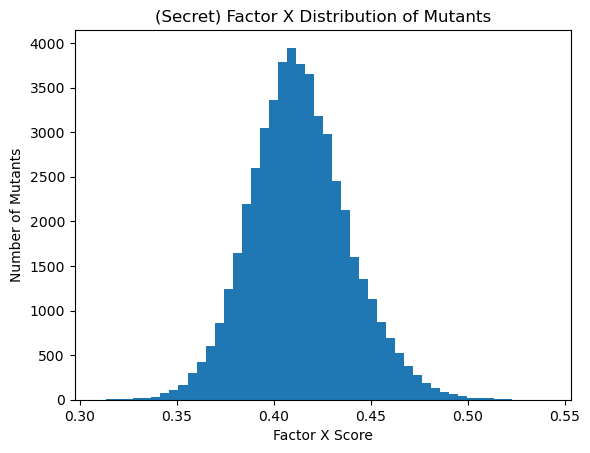

Filtering by pseudo-log likelihood ratio
Analyzing wildtype sequence
Analyzing mutant sequences


100%|██████████| 98/98 [02:24<00:00,  1.47s/it]


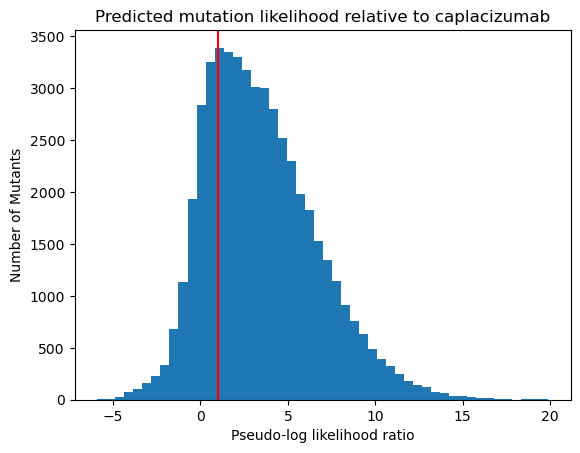

###############################################################################
Starting rep 1 of 3
###############################################################################
1: Selecting a batch of 384 samples without lab data
1: Submitting samples for lab analysis


   _____ __                  __   __               __      _____                           _                __           __                
  / ___// /_____ _____  ____/ /  / /_  ____ ______/ /__   /  _( )____ ___     ____ _____  (_)___  ____ _   / /_____     / /________  __    
  \__ \/ __/ __ `/ __ \/ __  /  / __ \/ __ `/ ___/ //_/   / / |// __ `__ \   / __ `/ __ \/ / __ \/ __ `/  / __/ __ \   / __/ ___/ / / /    
 ___/ / /_/ /_/ / / / / /_/ /  / /_/ / /_/ / /__/ ,<    _/ /   / / / / / /  / /_/ / /_/ / / / / / /_/ /  / /_/ /_/ /  / /_/ /  / /_/ /     
/____/\__/\__,_/_/ /_/\__,_/  /_.___/\__,_/\___/_/|_|  /___/  /_/ /_/ /_/   \__, /\____/_/_/ /_/\__, /   \__/\____/   \__/_/   \__, /      
                          

100%|██████████| 384/384 [00:03<00:00, 98.72it/s]



1: Training scoring model on lab results


Running tokenizer on dataset:   0%|          | 0/307 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

{'loss': 0.0187, 'grad_norm': 0.13239938020706177, 'learning_rate': 5.897435897435898e-05, 'epoch': 0.41}
{'loss': 0.0007, 'grad_norm': 0.04529406875371933, 'learning_rate': 1.794871794871795e-05, 'epoch': 0.82}
{'eval_loss': 0.0004900854546576738, 'eval_runtime': 0.3042, 'eval_samples_per_second': 253.138, 'eval_steps_per_second': 32.875, 'epoch': 1.0}
{'train_runtime': 4.1543, 'train_samples_per_second': 73.899, 'train_steps_per_second': 9.388, 'train_loss': 0.008069939887485443, 'epoch': 1.0}
***** train metrics *****
  epoch                    =        1.0
  train_loss               =     0.0081
  train_runtime            = 0:00:04.15
  train_samples            =        307
  train_samples_per_second =     73.899
  train_steps_per_second   =      9.388
{'eval_loss': 0.0004900854546576738, 'eval_runtime': 0.3002, 'eval_samples_per_second': 256.52, 'eval_steps_per_second': 33.314, 'epoch': 1.0}
***** eval metrics *****
  epoch                   =        1.0
  eval_loss               

Running tokenizer on dataset (num_proc=4):   0%|          | 0/37883 [00:00<?, ? examples/s]

100%|██████████| 37/37 [02:13<00:00,  3.62s/it]


1: Top-5 candidates so far


,seq,mutation,lab_result,pplr,last_prediction
id,,,,,
b0fec9,EVQLVESGGGLVQPGGSLRLSCAASMQTFYYNPMGWFRQAPGKGRE...,"[51, 54, 112, 56, 25, 98, 26, 29, 52]",0.496388,11.082010,0.415866
222190,EVQLVESGGGLVQPGGSLRLSCAASGRTFNYNPMGWFRQAPGKGRE...,"[111, 51, 101, 54, 102, 115, 104, 113, 29]",0.491541,11.726310,0.414084
040336,EVQLVESGGGLVQPGGSLRLSCAASGRTFHYRPMGWFRQAPGKGRE...,"[103, 29, 51, 31, 107, 98, 102, 28, 55, 111]",0.489599,8.664235,0.417945
72ade1,EVQLVESGGGLVQPGGSLRLSCAASGRTFFYNPMGWFRQAPGKGRE...,"[110, 107, 29, 98, 112, 54, 56, 109, 100]",0.486197,8.780797,0.414849
e851b6,EVQLVESGGGLVQPGGSLRLSCAASGRLFSYNPMGWFRQAPGKGRE...,"[112, 99, 55, 27, 110, 108, 115, 52]",0.473115,2.895347,0.413508


###############################################################################
Starting rep 2 of 3
###############################################################################
2: Selecting batch of the highest-scoring 384 samples without lab data
2: Submitting samples for lab analysis


   _____ __                  __   __               __      _____                           _                __           __                
  / ___// /_____ _____  ____/ /  / /_  ____ ______/ /__   /  _( )____ ___     ____ _____  (_)___  ____ _   / /_____     / /________  __    
  \__ \/ __/ __ `/ __ \/ __  /  / __ \/ __ `/ ___/ //_/   / / |// __ `__ \   / __ `/ __ \/ / __ \/ __ `/  / __/ __ \   / __/ ___/ / / /    
 ___/ / /_/ /_/ / / / / /_/ /  / /_/ / /_/ / /__/ ,<    _/ /   / / / / / /  / /_/ / /_/ / / / / / /_/ /  / /_/ /_/ /  / /_/ /  / /_/ /     
/____/\__/\__,_/_/ /_/\__,_/  /_.___/\__,_/\___/_/|_|  /___/  /_/ /_/ /_/   \__, /\____/_/_/ /_/\__, /   \__/\____/   \__/_/   \__, /      
        

100%|██████████| 384/384 [00:03<00:00, 98.70it/s]



2: Training scoring model on lab results


Running tokenizer on dataset:   0%|          | 0/307 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

{'loss': 0.005, 'grad_norm': 0.17715683579444885, 'learning_rate': 5.897435897435898e-05, 'epoch': 0.41}
{'loss': 0.0008, 'grad_norm': 0.01540222018957138, 'learning_rate': 1.794871794871795e-05, 'epoch': 0.82}
{'eval_loss': 0.0005683200433850288, 'eval_runtime': 0.3006, 'eval_samples_per_second': 256.148, 'eval_steps_per_second': 33.266, 'epoch': 1.0}
{'train_runtime': 4.1697, 'train_samples_per_second': 73.626, 'train_steps_per_second': 9.353, 'train_loss': 0.002520744664928852, 'epoch': 1.0}
***** train metrics *****
  epoch                    =        1.0
  train_loss               =     0.0025
  train_runtime            = 0:00:04.16
  train_samples            =        307
  train_samples_per_second =     73.626
  train_steps_per_second   =      9.353
{'eval_loss': 0.0005683200433850288, 'eval_runtime': 0.2966, 'eval_samples_per_second': 259.632, 'eval_steps_per_second': 33.718, 'epoch': 1.0}
***** eval metrics *****
  epoch                   =        1.0
  eval_loss               

Running tokenizer on dataset (num_proc=4):   0%|          | 0/37883 [00:00<?, ? examples/s]

100%|██████████| 37/37 [02:13<00:00,  3.62s/it]


2: Top-5 candidates so far


,seq,mutation,lab_result,pplr,last_prediction
id,,,,,
b0fec9,EVQLVESGGGLVQPGGSLRLSCAASMQTFYYNPMGWFRQAPGKGRE...,"[51, 54, 112, 56, 25, 98, 26, 29, 52]",0.496388,11.082010,0.417278
005fb0,EVQLVESGGGLVQPGGSLRLSCAASMRTFWYRPMGWFRQAPGKGRE...,"[54, 115, 31, 29, 25, 51, 29, 111]",0.492771,12.525146,0.417531
bd8143,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[106, 54, 104, 99, 53, 103, 116, 112, 102, 51]",0.491566,10.604052,0.415452
222190,EVQLVESGGGLVQPGGSLRLSCAASGRTFNYNPMGWFRQAPGKGRE...,"[111, 51, 101, 54, 102, 115, 104, 113, 29]",0.491541,11.726310,0.413478
040336,EVQLVESGGGLVQPGGSLRLSCAASGRTFHYRPMGWFRQAPGKGRE...,"[103, 29, 51, 31, 107, 98, 102, 28, 55, 111]",0.489599,8.664235,0.415607


###############################################################################
Starting rep 3 of 3
###############################################################################
3: Selecting batch of the highest-scoring 384 samples without lab data
3: Submitting samples for lab analysis


   _____ __                  __   __               __      _____                           _                __           __                
  / ___// /_____ _____  ____/ /  / /_  ____ ______/ /__   /  _( )____ ___     ____ _____  (_)___  ____ _   / /_____     / /________  __    
  \__ \/ __/ __ `/ __ \/ __  /  / __ \/ __ `/ ___/ //_/   / / |// __ `__ \   / __ `/ __ \/ / __ \/ __ `/  / __/ __ \   / __/ ___/ / / /    
 ___/ / /_/ /_/ / / / / /_/ /  / /_/ / /_/ / /__/ ,<    _/ /   / / / / / /  / /_/ / /_/ / / / / / /_/ /  / /_/ /_/ /  / /_/ /  / /_/ /     
/____/\__/\__,_/_/ /_/\__,_/  /_.___/\__,_/\___/_/|_|  /___/  /_/ /_/ /_/   \__, /\____/_/_/ /_/\__, /   \__/\____/   \__/_/   \__, /      
        

100%|██████████| 384/384 [00:03<00:00, 98.75it/s]



3: Top-5 candidates so far


,seq,mutation,lab_result,pplr,last_prediction
id,,,,,
b0fec9,EVQLVESGGGLVQPGGSLRLSCAASMQTFYYNPMGWFRQAPGKGRE...,"[51, 54, 112, 56, 25, 98, 26, 29, 52]",0.496388,11.082010,0.417278
005fb0,EVQLVESGGGLVQPGGSLRLSCAASMRTFWYRPMGWFRQAPGKGRE...,"[54, 115, 31, 29, 25, 51, 29, 111]",0.492771,12.525146,0.417531
a2a29a,EVQLVESGGGLVQPGGSLRLSCAASGRTFFYNPMGWFRQAPGKGRE...,"[101, 102, 100, 110, 109, 29, 55, 105]",0.492025,3.999183,0.415991
bd8143,EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRE...,"[106, 54, 104, 99, 53, 103, 116, 112, 102, 51]",0.491566,10.604052,0.415452
222190,EVQLVESGGGLVQPGGSLRLSCAASGRTFNYNPMGWFRQAPGKGRE...,"[111, 51, 101, 54, 102, 115, 104, 113, 29]",0.491541,11.726310,0.413478


In [ ]:
#################################
# Generate
#################################
print(f"Generating {SEQ_GENERATION_SIZE} random variants")
generated_seqs = helpers.random_mutation(
    wt_protein=str(caplacizumab_seq),
    n_output_seqs=SEQ_GENERATION_SIZE,
    preserved_regions=preserved_regions,
    max_mutations=MAX_MUTATIONS,
)

#################################
# Filter by pseudo-log likelihood ratio
#################################
print("Filtering by pseudo-log likelihood ratio")
generated_seqs["pplr"] = helpers.compute_pseudo_log_likelihood_ratio(
    str(caplacizumab_seq), generated_seqs["seq"]
)
generated_seqs = generated_seqs[generated_seqs["pplr"] > 1]

for rep in range(N_REPS):

    #################################
    # Select Samples for Lab Analysis
    ################################

    print("#" * 79 + "\n" + f"Starting rep {rep+1} of {N_REPS}" + "\n" + "#" * 79)
    no_lab_data = generated_seqs[generated_seqs["lab_result"].isnull()]
    if rep == 0:
        print(
            f"{rep+1}: Selecting a batch of {LAB_SUBMISSION_SIZE} samples without lab data"
        )
        selected_seqs = no_lab_data.sample(n=LAB_SUBMISSION_SIZE)
    else:
        print(
            f"{rep+1}: Selecting batch of the highest-scoring {LAB_SUBMISSION_SIZE} samples without lab data"
        )
        no_lab_data = no_lab_data.sort_values(by="last_prediction", ascending=False)
        selected_seqs = no_lab_data.sample(n=LAB_SUBMISSION_SIZE)

    #################################
    # Submit to Lab
    #################################

    print(f"{rep+1}: Submitting samples for lab analysis")
    lab_results = helpers.submit_seqs_to_lab(
        selected_seqs["seq"], delay=0.01, intro=True
    )

    for result in lab_results.itertuples():
        generated_seqs.loc[[result.Index], ["lab_result"]] = result.result

    # Skip the fine-tuning and scoring during the last round
    if rep + 1 < N_REPS:

        #################################
        # Fine-Tune on Lab Results
        #################################

        print(f"\n{rep+1}: Training scoring model on lab results")
        scoring_model = helpers.train_scoring_model(
            lab_results,
            sequence_column="seq",
            results_column="result",
            epochs=1,
            model_name_or_path=MODEL_ID if rep == 0 else "output",
        )

        #################################
        # Score all Generated Samples
        #################################

        print(f"\n{rep+1}: Using model to score all {SEQ_GENERATION_SIZE} sequences")
        predictions = helpers.run_scoring_model(generated_seqs, batch_size=1024)
        generated_seqs["last_prediction"] = predictions

    print(f"\n{rep+1}: Top-5 candidates so far")
    top_5 = generated_seqs.sort_values(by="lab_result", ascending=False)[:5]
    display(top_5)

In [15]:
print(
    str(0.39971).rjust(5)
    + "\t"
    + helpers.format_cdrs(str(caplacizumab_seq), cdrs, mask=False)
)
for i in top_5.itertuples():
    print(
        str(round(i.lab_result, 5)).rjust(5)
        + "\t"
        + helpers.format_cdrs(i.seq, i.mutation, mask=True)
    )

0.39971	EVQLVESGGGLVQPGGSLRLSCAASGRTFSYNPMGWFRQAPGKGRELVAAISRTGGSTYYPDSVEGRFTISRDNAKRMVYLQMNSLRAEDTAVYYCAAAGVRAEDGRVRTLPSEYTFWGQGTQVTVSS
0.49639	-------------------------MQ--Y---------------------RT-H-Y-----------------------------------------K-------------H---------------
0.49277	-------------------------M---W-R-------------------H--S--------------------------------------------------------M---R------------
0.49203	-----------------------------F-------------------------I--------------------------------------------RKF--F---FH-----------------
0.49157	---------------------------------------------------D-LC--------------------------------------------W--NMW-Y-----K---F-----------
0.49154	-----------------------------N---------------------W--W----------------------------------------------WM-D------Y-T-P------------


We have successfully found several mutants with better Factor X scores than caplacizumab, but there is still plenty of room for improvement. Think you can do better?

## 10. Your turn

Feel free to keep experimenting. Some things to try:

- Fine-tune one of the  the larger pre-trained models, like `esm2_t30_150M_UR50D` or `esm2_t33_650M_UR50D`
- Randomly generate more or fewer sequences
- Increase the number of possible mutations (as high as 30)
- Try generating a batch of variants, identifying the highest-scoring ones, then generating more variants from those! This method, called "directed evolution", can be a powerful technique for rapidly producing sequences with a desired property.
